# L09: Analyzing Monte Carlo Markov Chains

**Sources and additional reading:**

- MacKay, [Information Theory, inference, and learning algorithms](http://www.inference.org.uk/mackay/itila/book.html)

- [Roy, 2020](https://ui.adsabs.harvard.edu/abs/2020AnRSA...7..387R/abstract)

- [Akeret et al., 2013](https://ui.adsabs.harvard.edu/abs/2013A%26C.....2...27A/abstract)

- Davide Gerosa, [astrostatistics](https://github.com/dgerosa/astrostatistics_bicocca_2022)

## Introduction

In our discussion of Markov Chains and MCMCs we stated that ergodic Markov chains have a steady state and the MCMC will converge to its steady-state distribution $P(X)$ as the number of samples approaches infinity, i.e. $n\to\infty$.

The question we ask ourselves when performing an MCMC analysis is: Has my chain converged? How long do I need to run my chain for it to converge?

Unfortunately, there is no simple answer to this question. Essentially, we know that it will converge after infinitely many iterations, but since we can't perform so many iterations we can never be sure that there isn't another peak in the posterior which we just haven't discovered yet. There are however a number of tests that will tell us very clearly that our chain has not converged.

Here we will discuss the following tests:

**Visualization of samples/Burn-in** 

**Acceptance fraction**

**Autocorrelation time**

**Gelman-Rubin convergence test**

In general, it is recommended to perform all of these tests (usually in the order as above) to test if the chain shows suspicious behavior.

## Toy problem

Let us look at a two-dimensional Gaussian likelihood, specified by the following mean $\mu$ and covariance $C$.

In [38]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
mu = np.array([2, 5.])
sigma_x = 0.1
sigma_y = 0.2
r = 0.3
C = np.array([[sigma_x**2, r*sigma_x*sigma_y], [r*sigma_x*sigma_y, sigma_y**2]])
Cinv = np.linalg.inv(C)

class multnormal(object):
    
    def __init__(self):
        pass
    
    def getLogLikelihood(self, x):
        """
        Likelihood function.
        Args:
        x (:obj:`integer`, `float` or `array`): parameter value

        Returns:
            loglike (:obj:`integer`, `float` or `array`): log likelihood values of x
        """
        
        delta = x - mu
        loglike = -np.dot(np.dot(delta, Cinv), delta)/2.
        
        return loglike

In [40]:
like = multnormal()

In [52]:
import sys
sys.path.append('scripts')
from MHSampler import MHsampler

# intial position
init = np.array([0, 12])
# proposal variance chosen as 1
cov = np.array([[0.01, 0], [0, 0.13]])
# cov = np.array([[1., 0], [0, 1.]])
# cov = np.array([[0.0001, 0], [0, 0.0001]])
# run sampler
chain, likes = MHsampler(like, init, cov, 5000)

## Visualization and burn-in

Depending on where you initialize the MCMC, you might end up in a region of parameter space quite far from where the target distribution peaks. It will then take the MCMC some time to reach a relevant region of parameter space and thus the beginning of the chain will not be a draw from the target distribution. This is called *burn-in*. Typically you don't know where your target distribution peaks and so in most cases it's a good idea to look at the parameter value as a function of iteration (so-called *trace plots*) and discard the beginning of the chain. For a converged chain, the mean and the variance of the trace plot should be approximately constant.

In [53]:
mean = np.mean(chain[1000:, :], axis=0)
std = np.std(chain[1000:, :], axis=0, ddof=1)

print('Mean = {}.'.format(mean))
print('Std = {}.'.format(std))

Mean = [2.01028049 4.99138892].
Std = [0.10246893 0.20253137].


Text(0, 0.5, '$\\mu_x$')

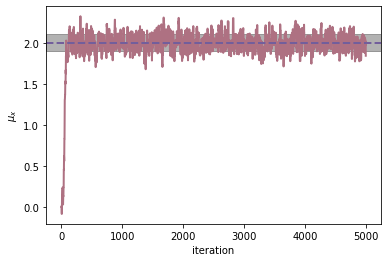

In [54]:
plt.plot(chain[:, 0], linewidth=2, color='#AE7182')
plt.axhspan(mean[0]-std[0], mean[0]+std[0], color='k', alpha=0.3, zorder=-1)
plt.axhline(mean[0], linestyle='--', linewidth=2, color='#725e9c')
plt.xlabel('iteration')
plt.ylabel(r'$\mu_x$')

Text(0, 0.5, '$\\mu_y$')

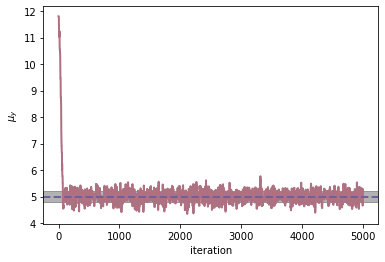

In [44]:
plt.plot(chain[:, 1], linewidth=2, color='#AE7182')
plt.axhspan(mean[1]-std[1], mean[1]+std[1], color='k', alpha=0.3, zorder=-1)
plt.axhline(mean[1], linestyle='--', linewidth=2, color='#725e9c')
plt.xlabel('iteration')
plt.ylabel(r'$\mu_y$')

## Acceptance fraction

The fraction of accepted samples in an MCMC $a_f$ (i.e. those steps where the MCMC actually moves) is a useful diagnostic tool. Let us first look at the two limiting cases:

$a_f = 0$: When the acceptance fraction is very low this means that almost no samples are accepted and the chain is thus extremely correlated and not exploring parameter space.

$a_f = 1$: When the acceptance fraction is very high then almost all proposed steps are accepted. This means that the chain is essentially performing a random walk which means that it will take a long time to explore parameter space (as random walks take a long time to get anywhere). 

The optimal lies somewhere in-between. Usually, the rule-of-thumb is that the acceptance fraction should lie in the range $a_f\sim 0.2 - 0.5$, to have chains that explore the target distribution efficiently.

Within the Metropolis-Hastings algorithm, you can usually control the acceptance fraction through the proposal distribution: If your proposal step is too large, then you will end up rejecting most of the samples as (especially in high dimensions) a large step will bring you to a region of parameter space with low probability. So low acceptance fractions can often be improved by decreasing the width of the proposal distribution. If on the other hand, the proposal step size is very small, then the target distribution won't change much and you will end up accepting most of the samples, essentially performing a random walk. As before, high acceptance fractions can be improved by increasing the width of the proposal distribution.

## Autocorrelation time

### Estimating the autocorrelation time

The samples returned by an MCMC are not independent. Therefore, assessing how many samples we need to achieve a given precision for the quantities we are interested in, requires us to estimate the effective number of independent samples in our chain. This is closely linked to the *autocorrelation time* of our chain.

In order to illustrate this concept, let us consider a function $f(\theta)$ with mean $$\bar{f}=\int\mathrm{d}\theta f(\theta)p(\theta),$$ which we would like to determine. Let us also assume that we have an MCMC sample $\{\theta_t\}$ of the pdf $p(\theta)$.

The autocorrelation $C_{ff}$ of $f(\theta)$ at time-lag $T$ is defined as $$C_{ff}(T)=\langle (f(\theta_t)-\bar{f})(f(\theta_{t+T})-\bar{f})\rangle_{t},$$ i.e. this is a measure of the correlation between samples separated by a time-lag $T$. If the points were independent, then $C_{ff}(T)$ would vanish for $T\geq1$. For MCMCs, $C_{ff}$ typically decreases exponentially with $T$, i.e. $C_{ff}\propto e^{-T/\tau_{ff}},$ where we have defined the *autocorrelation time* $\tau_{ff}$ of the MCMC for the function $f$.

We further define the normalized autocorrelation function as $$\rho_{ff}(T)=\frac{C_{ff}(T)}{C_{ff}(0)},$$ and the (exponential) autocorrelation time $\tau_{ff}$ is formally defined as $$\tau_{ff}\simeq \limsup_{T\to\infty} \frac{T}{-\log{|\rho_{ff}(T)|}}.$$ 

We can estimate the autocorrelation function from a given sample of length $n$ as $$C_{ff}(T)=\frac{1}{n-T}\sum_{t=1}^{n-T}(f(\theta_t)-\bar{f})(f(\theta_{t+T})-\bar{f}).$$ This estimator tends to be very noisy, especially at high $T$, which complicates estimating the autocorrelation time. In practice $C_{ff}(T)$ and thus $\rho_{ff}(T)$ are often exponentially decaying. Therefore, the most stable way to estimate $\tau_{ff}$ is to fit $\rho_{ff}(T)$ with an exponential function for moderately large $T$, and estimate the autocorrelation time from the fit.

### Usage

The autocorrelation time determines the correlation length of an MCMC and thus provides a measure for the effective number of independent samples in the chain. More specifically, for our example above the error on the mean of the function $f(\theta)$ for an MCMC of length $n$ is given by $$\sigma(\bar{f})=\frac{2\tau_{ff}}{n}\sigma(f(\theta_t)),$$ i.e. we see that the correlation between subsequent points reduces the effective sample size from $n$ to $\frac{n}{2\tau_{ff}}$.

The autocorrelation time is very powerful, as it tells us 

(i) how long we need to sample to get indpendent points, i.e. it provides a starting guess for the burn-in we need to remove. Generally, we would like to sample for a number of autocorrelation times so as to allow the chain to forget its initial state.

(ii) how long we need to sample to achieve a given precision on the mean of our function $f$.

## Gelman-Rubin convergence test

The Gelman-Rubin convergence test is one of the most popular convergence tests for MCMCs and relies on the availability of several chains. Essentially it tests if the variance within each chain is consistent with the variance across different chains.

The procedure is as follows:

1. Run $m$ different chains each of length $n$, i.e. $\{X_{i1}, \cdots X_{in}\}, i=1,\cdots m$. The starting points for these chains should be overdispersed with respect to the target density.

2. Calculate the variance for each chain $s_i^2=\frac{1}{n-1}\sum_{j=1}^n (X_{ij}-\bar{X}_i)^2, i=1,\cdots m$.

3. Define the mean of the within-chain variances as $W = \frac{1}{m}\sum_{i=1}^m s_i^2$.

4. Compute the between-chain variance as $B=\frac{n}{m-1}\sum_{i=1}^m (\bar{X}_i - \bar{X})^2$, where $\bar{X}=\frac{1}{m}\sum_{i=1}^m \bar{X}_i$. Note that we have multiplied $B$ by $n$ as we essentially estimate the variance in the mean of the chains which is reduced by a factor of $n$ for a sample of size $n$.

5. Estimate the variance of the stationary distribution as a weighted average between $W$ and $B$ as $\hat{V}=\frac{n-1}{n}W+\frac{B}{n}$.

6. Then we can compute the Gelman-Rubin statistic $R$ as $$R=\frac{\hat{V}}{W}.$$ If this quantity is close to 1 (generally the cutoff is $R\leq1.01$), this is evidence that the chain has converged.

**Explanation:** Both $\hat{V}$ and $W$ are unbiased estimators of the variance if the chain is converged. However, if this is not the case, then we expect $\hat{V}$ to overestimate the variance because of $B$, while we expect $W$ to underestimate the variance (has not explored enough). So we expect $R\geq1$, with $R\sim1$ for converged chains. Note also that $R\to1$ for $n\to\infty$ as expected. It is important to point out that $R\sim1$ is a neccessary but not sufficient condition for convergence, i.e. even chains with $R=1$ might be unconverged if they e.g. all sit in one local minimum.

**Note:** Another good test is to inspect data splits, e.g. is the second half of the chain statistically consistent with the first half.

In [10]:
# intial position
init = np.array([6, -3])
# proposal variance chosen as 1
cov = np.array([[0.01, 0], [0,0.13]])
# run sampler
chain1, likes1 = MHsampler(like, init, cov, 5000)

Text(0, 0.5, '$\\mu_x$')

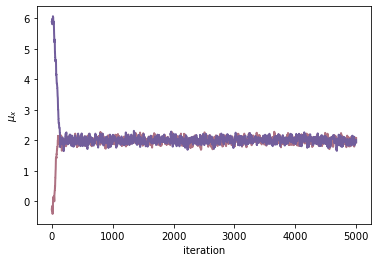

In [11]:
plt.plot(chain[:, 0], linewidth=2, color='#AE7182')
plt.plot(chain1[:, 0], linewidth=2, color='#725e9c')
plt.xlabel('iteration')
plt.ylabel(r'$\mu_x$')

Text(0, 0.5, '$\\mu_y$')

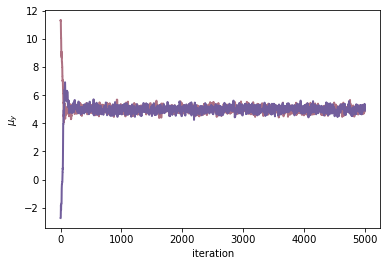

In [12]:
plt.plot(chain[:, 1], linewidth=2, color='#AE7182')
plt.plot(chain1[:, 1], linewidth=2, color='#725e9c')
plt.xlabel('iteration')
plt.ylabel(r'$\mu_y$')

## Bayesian model comparison

So far we have learned how to compute posterior probabilities for parameters within a given model. This essentially allows us to assess the relative probability of different sets of parameters within a fixed model. 

Let us now assume that we have two models, $M_1$ and $M_2$, with two different sets of associated model parameters, $\boldsymbol{\theta}_1$ and $\boldsymbol{\theta}_1$, of dimension $d_1$ and $d_2$. Given observed data $\boldsymbol{x}$, our task is to decide which of the two models is favored by the data.

In order to answer this question, we can start with Bayes' theorem for a general model $M$. We have that $$P(\boldsymbol{\theta}, M|\boldsymbol{x}) = \frac{P(\boldsymbol{x}|\boldsymbol{\theta}, M)P(\boldsymbol{\theta}, M)}{P(\boldsymbol{x})}.$$ What we are interested in is the probability of the model given the data, i.e. $P(M|\boldsymbol{x}),$ which we can obtain by integrating $P(\boldsymbol{\theta}, M|\boldsymbol{x})$ over all model parameters, i.e. $$P(M|\boldsymbol{x})=\int\mathrm{d}\boldsymbol{\theta} \;P(\boldsymbol{\theta}, M|\boldsymbol{x}) = \int\mathrm{d}\boldsymbol{\theta} \; \frac{P(\boldsymbol{x}|\boldsymbol{\theta}, M)P(\boldsymbol{\theta}, M)}{P(\boldsymbol{x})}=\frac{P(M)}{P(\boldsymbol{x})}\int \mathrm{d}\boldsymbol{\theta} \; P(\boldsymbol{x}|\boldsymbol{\theta}, M)P(\boldsymbol{\theta}| M).$$ The last term in the equation is the evidence we have discussed when introducing Bayes' theorem, i.e. the probability of observing a given data set $\boldsymbol{x}$ given model $M$. We therefore have that $$P(M|\boldsymbol{x}) = \frac{P(\boldsymbol{x}|M)P(M)}{P(\boldsymbol{x})}.$$ 

This provides a framework within which to compare our two models $M_1$, $M_2$. We can compute the ratio between posterior probabilities of the two models (the so-called odds ratio), defined as $$O_{12}=\frac{P(M_1|\boldsymbol{x})}{P(M_2|\boldsymbol{x})}=\frac{P(\boldsymbol{x}|M_1)P(M_1)}{P(\boldsymbol{x}|M_2)P(M_2)}=B_{12}\frac{P(M_1)}{P(M_2)},$$ where we have introduced the Bayes factor $$B_{12}=\frac{P(\boldsymbol{x}|M_1)}{P(\boldsymbol{x}|M_2)},$$ which encodes the ratio of the model evidences. In absence of a prior preference for one of the two models considered, i.e. $P(M_1)=P(M_2)$, the ratio between the posterior model probabilities is given by the ratio of model evidences.

A value $B_{12}\gt 1$ ($B_{12}\lt 1$) represents an increase (decrease) of the support in favor of model 1 versus model 2 given the observed data. In general, $B_{12}$ gives us the relative probability of the two models, but in analogy with our discussion of hypothesis testing, these ratios can also be interpreted using subjective thresholds. The most popular one is the Jeffrey's scale (1961), reproduced below for the Bayes factor which is equivalent to the odds ratio in the absence of prior model preferences (from [Trotta, 2017](https://arxiv.org/pdf/1701.01467.pdf)):

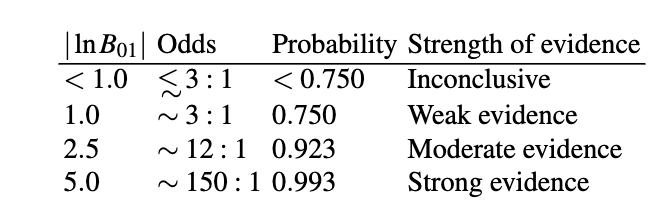

## Occam's razor - or the dependence of the evidence on model complexity 

Imagine we would like to compare two models of different complexity, a simple model $M_s$ and a complex model $M_c$ (e.g. a linear model vs. a higher-order polynomial). Generally, simpler models tend to make more precise predictions. More complex models on the other hand, are able to fit a wider variety of data, which means that $P(D|M_c)$ will be broader than $P(D|M_s)$. As both distributions need to be normalized over data space, the more complex model will thus assign lower predictive probabilities to the data (see Figure below). Therefore in the case in which the data are compatible with both models, the Bayes factor (and thus the odds ratio for flat priors) will lead us to prefer the simpler over the more complex model. Bayesian model selection therefore automatically encodes *Occam's razor*, which is the principle to "accept the simplest model that fits the data". 

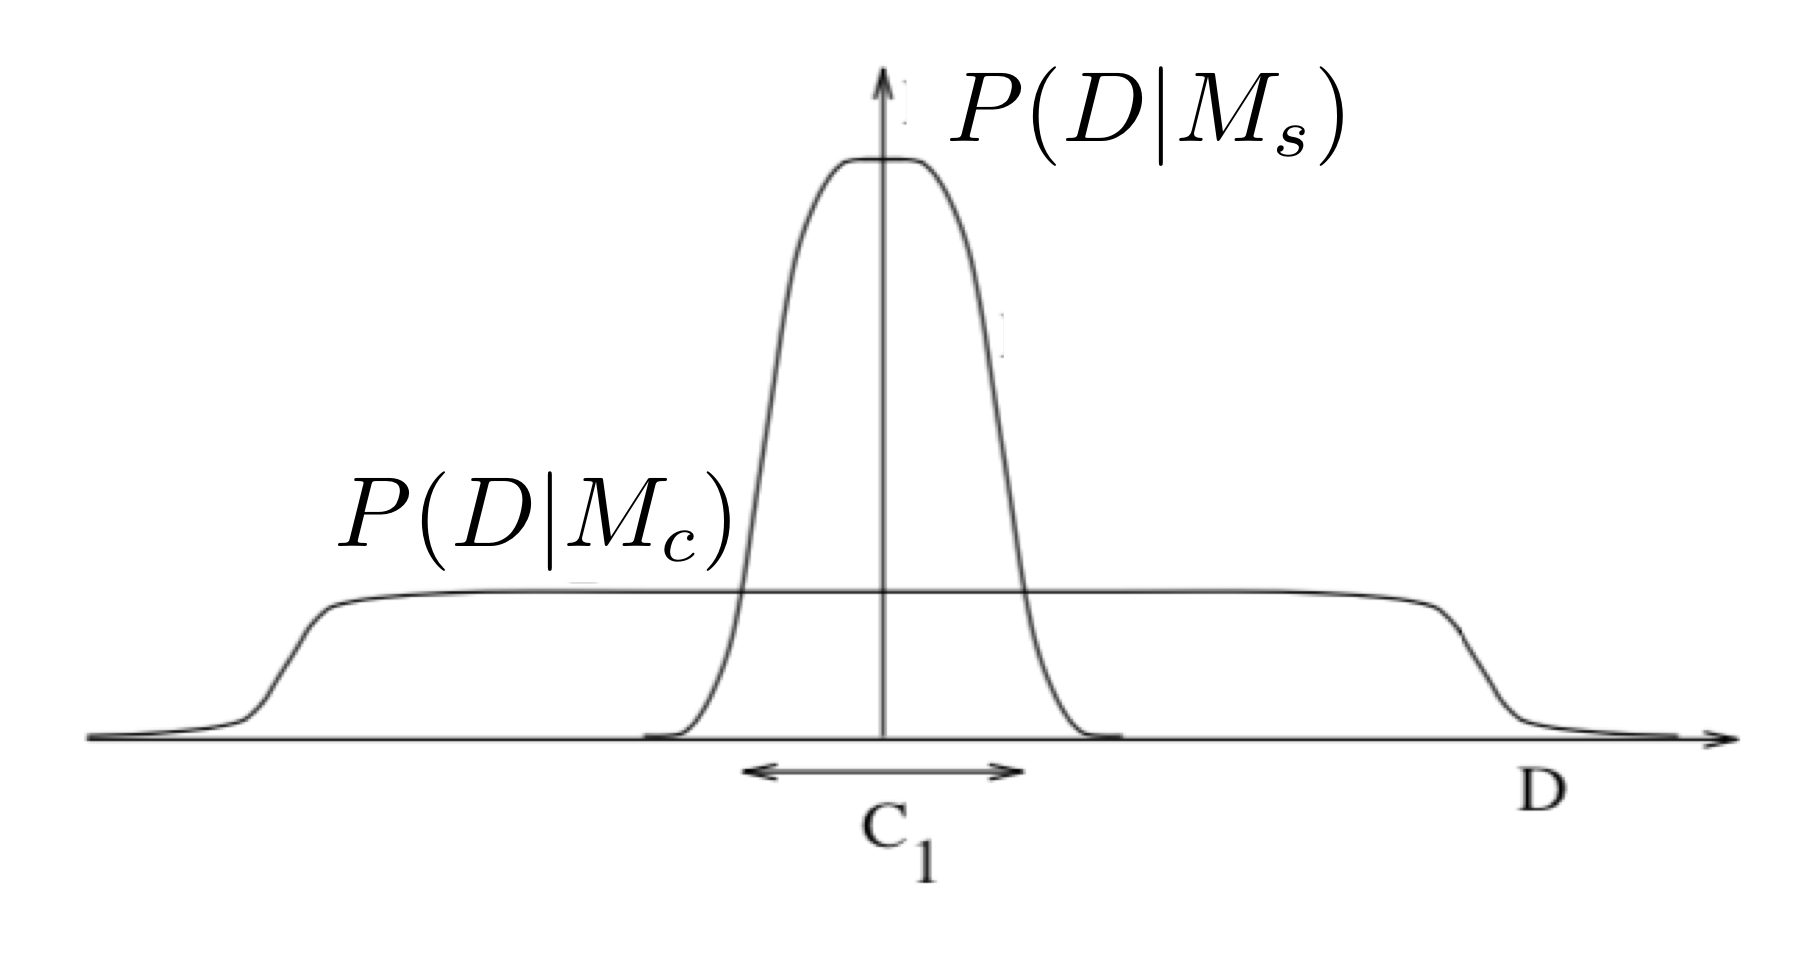

## How does the evidence penalize more complex models?

Let us look at the evidence more closely in order to understand how this effect comes about. The evidence is given by $$P(\boldsymbol{x}|M)=\int \mathrm{d}\boldsymbol{\theta} \; P(\boldsymbol{x}|\boldsymbol{\theta}, M)P(\boldsymbol{\theta}| M).$$ Often, the posterior $P(\boldsymbol{\theta} |\boldsymbol{x}, M)\propto P(\boldsymbol{x}|\boldsymbol{\theta}, M)P(\boldsymbol{\theta}| M)$ is sharply peaked around the maximum-a-posteriori $\boldsymbol{\theta}_{\mathrm{MAP}}$. This means that we can approximate the evidence as $$P(\boldsymbol{x}|M)\simeq P(\boldsymbol{x}|\boldsymbol{\theta}_{\mathrm{MAP}}, M)P(\boldsymbol{\theta}_{\mathrm{MAP}}| M)\Delta_{\mathrm{post}},$$ where $\Delta_{\mathrm{post}}$ denotes the width of the posterior. Assuming a uniform prior of width $\Delta_{\mathrm{prior}}$, we can further simplify this to $$P(\boldsymbol{x}|M)\simeq P(\boldsymbol{x}|\boldsymbol{\theta}_{\mathrm{MAP}}, M)\frac{\Delta_{\mathrm{post}}}{\Delta_{\mathrm{prior}}}.$$ Thus we see that the evidence can be approximated as the product of the likelihood at the best-fit parameters with the ratio of the posterior accessible volume (width in this case) and the prior accessible volume, the so-called Occam factor. In other words, the Occam factor quantifies by how much the model space collapses when data arrives.

Since $\Delta_{\mathrm{post}}\leq\Delta_{\mathrm{prior}}$, the Occam factor will always reduce the evidence. A more complex model with many parameters will generally have a smaller Occam factor, as its prior accessible volume will be large. For a given best-fit likelihood, the Occam factor will thus lead us to prefer the simpler model, as we discussed above. In addition, given the same model complexity and prior volume, the Occam factor also penalizes models that have to be finely tuned to fit the data, i.e. have small $\Delta_{\mathrm{post}}$ which could be a sign of overfitting.